# Building Powerful AI Applications

## Learning goals

1.   Learn how anyone can build a RAG application with minimal code
2.   Discover the potential sophistication of RAG apps
3.   Recognize the challenges in scaling and maintaining RAG apps without proper tools



# AI applications consists of many components

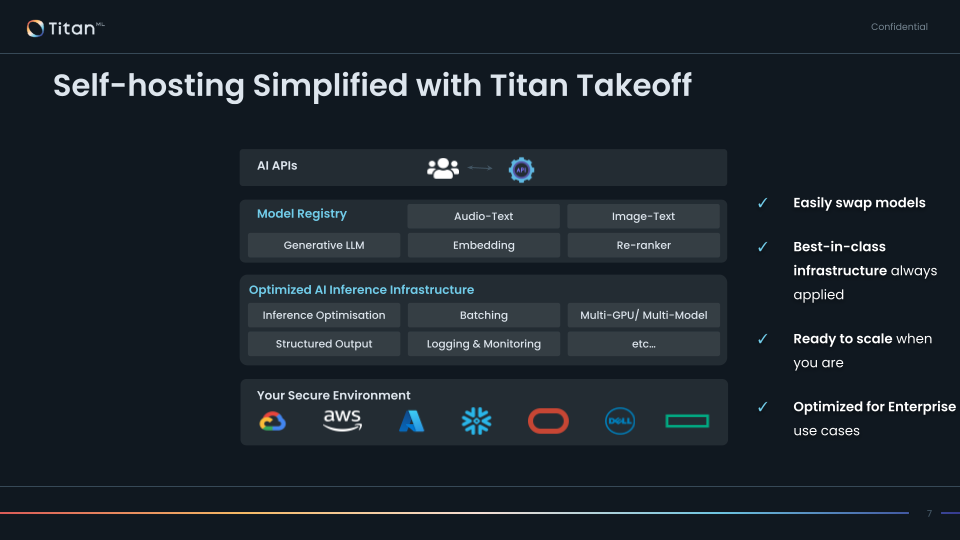

# We want to enable search, summarization, interrogation and text generation for our users

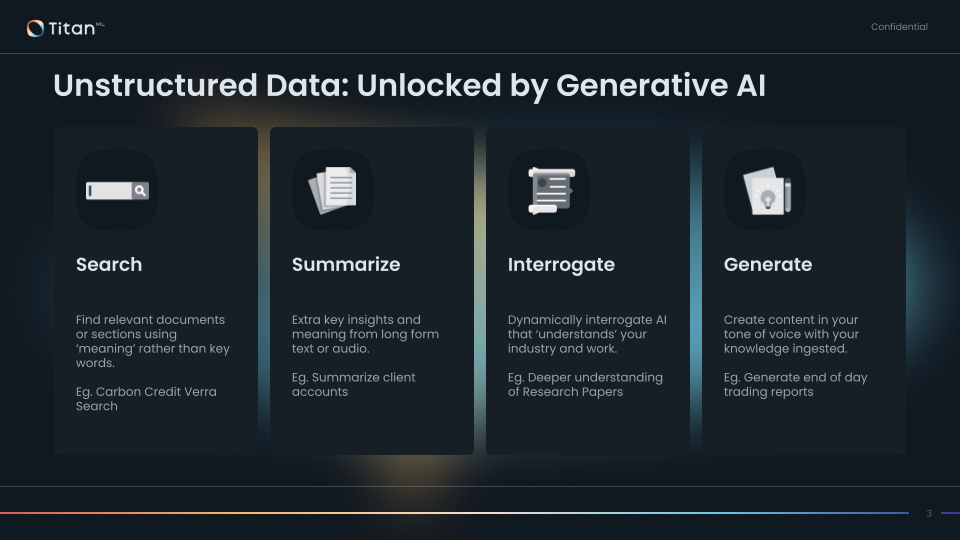

# We know that in many cases the answer for this is RAG

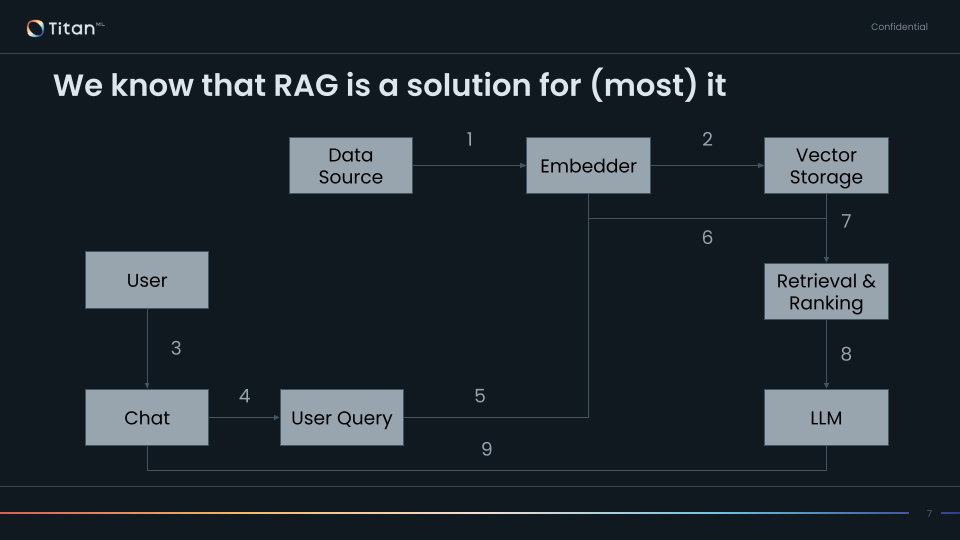

In [ ]:
!pip install openai

In [ ]:
!pip install takeoff_client

In [ ]:
import os
import re
import string
from typing import List, Tuple, Callable
from openai import OpenAI
from takeoff_client import TakeoffClient

In [ ]:
os.environ["TITAN_TAKEOFF"] = "TAKEOFF URL GOES HERE"
os.environ["TITAN_TAKEOFF_PORT"] = 'TAKEOFF PORT HERE'
os.environ["TITAN_TAKEOFF_PORT_MT"] = 'TAKEOFF PORT2 HERE'

In [ ]:
os.environ["PINECONE_API_KEY"] = "USE A PINECONE API KEY HERE"
os.environ["OPENAI_API_KEY"] = "USE AN OPENAI API KEY HERE"

# DataSource Class

- The `DataSource` class is responsible for preprocessing and tokenizing the input data. It provides methods to perform advanced text preprocessing techniques and tokenization on the data.

In [ ]:
class DataSource:
    def __init__(self, data: List[str]):
        self.data = data

    def preprocess_text(self, text: str) -> str:
      """
      Preprocesses the text by lowercasing, removing punctuation, and removing extra whitespace.

      Args:
          text (str): The input text to be preprocessed.

      Returns:
          str: The preprocessed text.
      """
      text = text.lower()
      text = text.translate(str.maketrans("", "", string.punctuation))
      text = re.sub(r"\s+", " ", text).strip()
      return text

    def tokenize(self, text: str) -> str:
      """
      Tokenizes the preprocessed text into a list of words.

      Args:
          text (str): The preprocessed text to be tokenized.

      Returns:
          List[str]: A list of tokens (words) from the text.
      """
      return self.preprocess_text(text).split()

    def process_data(self):
      """
      The process_data method applies the text preprocessing steps to each sentence
      in the input data and stores the processed data in the processed_data attribute.
      """
      self.processed_data = [self.preprocess_text(sentence) for sentence in self.data]


# UserQuery Class
- The `UserQuery` class represents a user's query. It is a simple class that encapsulates the query string.

In [ ]:
class UserQuery:
    def __init__(self, query: str):
        self.query = query

# Embedding Class
- The `Embedding` class is a placeholder for implementing text embedding functionality.
- The `embed` method takes a text string as input and returns a list of floating-point numbers representing the embedding vector for the given text.

In [ ]:
class Embedding:
    def __init__(self):
        pass

    def embed(self, text: str) -> List[float]:
        # Placeholder method for embedding text
        pass

# VectorStorage Class
- The `VectorStorage` class is a placeholder for implementing vector storage and retrieval functionality.
- It provides methods for storing embedding vectors and searching for similar vectors based on a query vector and a specified number of top results.

In [ ]:
class VectorStorage:
    def __init__(self):
        pass

    def store_vectors(self, vectors: List[List[float]]):
        # Placeholder method for storing vectors
        pass

    def search_vectors(self, query_vector: List[float], top_n: int) -> List[int]:
        # Placeholder method for searching vectors
        pass

# RetrievalAndRanking Class
- The `RetrievalAndRanking` class is responsible for retrieving relevant chunks from the data source based on a given query.
- The class takes a `DataSource` object, an `Embedding` object, and a `VectorStorage` object as input to perform the retrieval and ranking operations.

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

# LLM Class
- The LLM class has parameter `model_name` to specify the local model to use. If an `api_key` is provided, it uses OpenAI as before. Otherwise, it initializes the `TakeoffClient` and switches to the specified local model using the `switch_model` method.
- The `switch_model` method deletes any existing reader and creates a new reader with the specified `model_name` and `device`.
- The `answer_query` method checks if an `api_key` is provided. If so, it uses OpenAI to generate the answer. Otherwise, it uses the `TakeoffClient` to generate the answer using the specified local model.

In [ ]:
class LLM:
    def __init__(self, api_key: str = None, model_name: str = None, device: str = "cuda", consumer_group: str = "mistral"):
        self.api_key = api_key
        self.model_name = model_name
        self.device = device
        self.consumer_group = consumer_group

        if self.api_key:
            self.client = OpenAI(api_key=self.api_key)
        else:
            self.takeoff_client = TakeoffClient(base_url=os.environ.get("TITAN_TAKEOFF"),
                                                port=os.environ.get("TITAN_TAKEOFF_PORT"),
                                                mgmt_port=os.environ.get("TITAN_TAKEOFF_PORT_MT")
                                                )
            self.switch_model(model_name, device)

    def switch_model(self, model_name: str, device: str):
        current_readers = self.takeoff_client.get_readers()

        # Check if a reader for the desired model already exists
        reader_id = None
        for group, readers in current_readers.items():
            for reader in readers:
                if reader['model_name'] == model_name:
                    reader_id = reader['reader_id']
                    break
            if reader_id:
                break

        if reader_id:
            print(f"Reader for model '{model_name}' already exists with reader_id: {reader_id}")
        else:
            reader_config = {
                "model_name": model_name,
                "device": device,
                "consumer_group": self.consumer_group
            }

            reader_id, _ = self.takeoff_client.create_reader(reader_config=reader_config)
            print(f"Created a new reader with reader_id {reader_id}")

    def answer_query(self, query: str, context: str) -> str:
      prompt = f"Based on the provided context, answer the following query: {query}\n\nContext:\n{context}. Do not use your knowledge, only the context"
      if self.api_key:
          chat_completion = self.client.chat.completions.create(
              messages=[
                  {
                      "role": "system",
                      "content": prompt
                  },
                  {
                      "role": "user",
                      "content": query,
                  },
              ],
              model="gpt-3.5-turbo",
          )
          return chat_completion.choices[0].message.content.strip()
      else:
          response = self.takeoff_client.generate(prompt, consumer_group=self.consumer_group)
          if 'text' in response:
              return response['text'].strip()
          else:
              print(f"Error generating response: {response}")
              return "Unable to generate a response."

# Data

In [ ]:
# Carbon trading data source
data = [
    "Carbon trading is a market-based approach to reducing greenhouse gas emissions by providing economic incentives for companies to limit their carbon footprint.",
    "In a carbon trading system, companies are allocated a certain number of carbon credits, which represent the right to emit a specific amount of carbon dioxide or other greenhouse gases.",
    "Companies that emit less than their allocated carbon credits can sell their excess credits to companies that exceed their emissions limits, creating a market for carbon credits.",
    "The goal of carbon trading is to encourage companies to invest in cleaner technologies and adopt more sustainable practices to reduce their emissions and avoid the cost of purchasing additional carbon credits.",
    "Environmental, Social, and Governance (ESG) criteria are a set of standards used by investors to evaluate a company's sustainability and ethical impact.",
    "ESG factors consider a company's environmental impact, such as its carbon footprint, waste management, and use of renewable energy.",
    "Social aspects of ESG include a company's labor practices, diversity and inclusion policies, and community engagement.",
    "Governance factors in ESG assess a company's leadership structure, executive compensation, and transparency in decision-making processes.",
    "Investors are increasingly using ESG criteria to identify companies that are better positioned to manage risks and opportunities related to sustainability and social responsibility.",
    "Companies with strong ESG performance tend to have better long-term financial prospects, as they are more resilient to environmental and social challenges and are favored by environmentally and socially conscious consumers.",
    "Carbon trading and ESG are closely related, as companies with lower carbon emissions and better sustainability practices tend to have higher ESG ratings.",
    "Governments and international organizations are promoting carbon trading and ESG investing as key strategies for mitigating climate change and transitioning to a low-carbon economy.",
]

# process_query Function
- The `process_query` function is responsible for processing user queries and retrieving relevant answers based on the selected retrieval method.
- It takes the user queries, a `DataSource` object, a `RetrievalAndRanking` object, an `LLM` object, and a `retrieval_method` parameter as input.
- Depending on the retrieval method, it retrieves relevant chunks from the data source, generates an answer using the LLM object, and returns the answer.

In [ ]:
def process_query(query: str, data_source: DataSource, retrieval_and_ranking: RetrievalAndRanking, llm: LLM, retrieval_method: str = "default") -> str:
    user_query = UserQuery(query)

    if retrieval_method == "default":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks(user_query.query)
    else:
        raise ValueError(f"Unknown retrieval method: {retrieval_method}")

    context = "\n".join(relevant_chunks)
    answer = llm.answer_query(user_query.query, context)
    return answer

# main Function

In [ ]:
def main(data_source:DataSource, retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None, device: str = "cpu"
         ):
    embedding = Embedding()
    vector_storage = VectorStorage()
    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)
    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        llm = LLM(model_name=model_name, device=device)

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

## Possible Queries



*   Relevant: "What is the purpose of carbon trading?"
*   Relevant: "How do ESG criteria evaluate a company's environmental impact?"
* Irrelevant: "What is the recipe for making a perfect pizza?"



In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, model_choice="openai")

Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: The purpose of carbon trading is to encourage companies to invest in cleaner technologies and adopt more sustainable practices to reduce their emissions and avoid the cost of purchasing additional carbon credits.

Enter your query (or type 'exit' to quit): exit


### Let's go local!

Running a Mistral-7b model

In [ ]:
main(data_source, model_choice="local", model_name="mistralai/Mistral-7B-Instruct-v0.2")

Reader for model 'mistralai/Mistral-7B-Instruct-v0.2' already exists with reader_id: model_3
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: provided.

Answer:
The purpose of carbon trading is to create a market-based approach for reducing greenhouse gas emissions. In a carbon trading system, companies are given a certain number of carbon credits, which represent the right to emit a specific amount of carbon dioxide or other greenhouse gases. The goal is to encourage companies to invest in cleaner technologies and adopt more sustainable practices to reduce their emissions and avoid the cost of purchasing additional carbon credits. This system provides an economic incentive for reducing emissions, rather than relying solely on regulations.

Enter your query (or type 'exit' to quit): exit


But what happens, if we are not happy with Mistral and instead want to try a t5-small? No problem!

In [ ]:
main(data_source, model_choice="local", model_name="t5-small")

Reader for model 't5-small' already exists with reader_id: 5da3b0a8-ecd4-4479-98cb-96010b21fd94
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: provided.

Answer:
The purpose of carbon trading is to create a market-based approach for reducing greenhouse gas emissions. In a carbon trading system, companies are given a certain number of carbon credits, which represent the right to emit a specific amount of carbon dioxide or other greenhouse gases. The goal is to encourage companies to invest in cleaner technologies and adopt more sustainable practices to reduce their emissions and avoid the cost of purchasing additional carbon credits. This system provides an economic incentive for reducing emissions, rather than relying solely on regulations.

Enter your query (or type 'exit' to quit): exit


# Exercises


## Exercise 1: Preprocessing and Tokenization
- Update the `preprocess_text_advanced` method in the DataSource class to:
  - Convert the text to lowercase
  - Remove punctuation
  - Remove numeric characters
  - Remove stop words (e.g., "the", "and", "is")
  - Lemmatize the words (e.g., convert "running" to "run")
- Modify the `tokenize` method in the `DataSource` class to use the `preprocess_text_advanced` method.
- Update the `process_data` method in the `DataSource` class to use the `preprocess_text_advanced` method.

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from typing import List
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
class DataSource:
    def __init__(self, data: List[str]):
        self.data = data

    def preprocess_text(self, text: str) -> str:
      """
      Preprocesses the text by lowercasing, removing punctuation, and removing extra whitespace.

      Args:
          text (str): The input text to be preprocessed.

      Returns:
          str: The preprocessed text.
      """
      text = text.lower()
      text = text.translate(str.maketrans("", "", string.punctuation))
      text = re.sub(r"\s+", " ", text).strip()
      return text

    def preprocess_text_advanced(self, text: str) -> str:
        # Implement here
        pass

    def tokenize(self, text: str) -> str:
      """
      Tokenizes the preprocessed text into a list of words.

      Args:
          text (str): The preprocessed text to be tokenized.

      Returns:
          List[str]: A list of tokens (words) from the text.
      """

      #Update here
      return self.preprocess_text(text).split()

    def process_data(self):
      #Update here
      self.processed_data = [self.preprocess_text(sentence) for sentence in self.data]

### Answer

### Let's update

Possible queries:
- "What is the purpose of carbon trading?"
- "How do ESG criteria evaluate a company's environmental impact?"
- "What is the recipe for making a perfect pizza?"

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, model_choice="openai")

Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: The purpose of carbon trading is to provide a market-based approach for reducing greenhouse gas emissions by creating economic incentives for companies to limit their carbon footprint. This helps in promoting better sustainability practices and lower carbon emissions, which can lead to higher ESG (Environmental, Social, and Governance) ratings for companies.

Enter your query (or type 'exit' to quit): exit


Why do we want to explore more advanced approaches for data preprocessing? They help us fit more into the context window!

In [ ]:
data_source.processed_data

['carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint',
 'carbon trading system company allocated certain number carbon credit represent right emit specific amount carbon dioxide greenhouse gas',
 'company emit le allocated carbon credit sell excess credit company exceed emission limit creating market carbon credit',
 'goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit',
 'environmental social governance esg criterion set standard used investor evaluate company sustainability ethical impact',
 'esg factor consider company environmental impact carbon footprint waste management use renewable energy',
 'social aspect esg include company labor practice diversity inclusion policy community engagement',
 'governance factor esg ass company leadership structure executive compensation transparency decisionmaking proce

In [ ]:
data

['Carbon trading is a market-based approach to reducing greenhouse gas emissions by providing economic incentives for companies to limit their carbon footprint.',
 'In a carbon trading system, companies are allocated a certain number of carbon credits, which represent the right to emit a specific amount of carbon dioxide or other greenhouse gases.',
 'Companies that emit less than their allocated carbon credits can sell their excess credits to companies that exceed their emissions limits, creating a market for carbon credits.',
 'The goal of carbon trading is to encourage companies to invest in cleaner technologies and adopt more sustainable practices to reduce their emissions and avoid the cost of purchasing additional carbon credits.',
 "Environmental, Social, and Governance (ESG) criteria are a set of standards used by investors to evaluate a company's sustainability and ethical impact.",
 "ESG factors consider a company's environmental impact, such as its carbon footprint, waste ma

### Let's go local!

Running a Mistral-7b model

In [ ]:
main(data_source, model_choice="local", model_name="mistralai/Mistral-7B-Instruct-v0.2")

Reader for model 'mistralai/Mistral-7B-Instruct-v0.2' already exists with reader_id: model_3
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: .

Answer:
The purpose of carbon trading is to reduce greenhouse gas emissions through a market-based approach by providing an economic incentive for companies to limit their carbon footprint. This system allows companies to buy and sell carbon credits, enabling them to offset their own emissions by financing emission reduction projects elsewhere. This market mechanism tends to encourage better sustainability practices, as companies with lower carbon emissions and higher Environmental, Social, and Governance (ESG) ratings may have an advantage in the carbon trading market.

Enter your query (or type 'exit' to quit): exit


## Exercise 2: Similarity Metric

- Import the `euclidean_distances` from scikit-learn that calculates the euclidean distance between two text chunks.
- Create a `retrieve_relevant_chunks_euclidean` function to use the `euclidean_distances` function instead of the current similarity calculation.
- Implement the `retrieve_relevant_chunks_euclidean` method in the `RetrievalAndRanking` class using the euclidean distance metric from scikit learn.
- Remember to update our `process_query` function and `main` and include the new distance function
- Compare the results and discuss the pros and cons of each approach.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Implement this function to use euclidean distance instead of the current similarity calculation
      pass

### Answer

### Let's update

Possible queries:
- "What is the purpose of carbon trading?"
- "How do ESG criteria evaluate a company's environmental impact?"
- "What is the recipe for making a perfect pizza?"

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, "euclidean", model_choice="openai")

Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: The purpose of carbon trading is to provide companies with a system to allocate a certain number of carbon credits that represent the right to emit a specific amount of carbon dioxide or other greenhouse gases. This system allows companies to trade these credits in order to lower their carbon emissions and improve their sustainability practices, leading to a higher ESG (Environmental, Social, and Governance) rating.

Enter your query (or type 'exit' to quit): exit


### Let's go local!

Running a Mistral-7b model

In [ ]:
main(data_source, "euclidean", model_choice="local", model_name="mistralai/Mistral-7B-Instruct-v0.2")

Reader for model 'mistralai/Mistral-7B-Instruct-v0.2' already exists with reader_id: model_3
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: .

Answer:
The purpose of carbon trading is to provide a market-based approach for reducing greenhouse gas emissions. In this system, companies are allocated a certain number of carbon credits, which represent the right to emit a specific amount of carbon dioxide. Companies that can reduce their emissions below their allocated limit can sell their excess credits to other companies that need to buy credits to cover their emissions. This system incentivizes companies to lower their carbon emissions and promotes better sustainability practices, which can lead to higher Environmental, Social, and Governance (ESG) ratings.

Enter your query (or type 'exit' to quit): exit


# Learning

If we look at our diagram at the beginning, we see that we were able to implement a full RAG application without making use of a dedicated model for embedding.

All entirely with the power of an LLM local or cloud.

Why can't we stop there? Why should we introduce vector embeddings? **Let's discuss!**

# We have a basic RAG

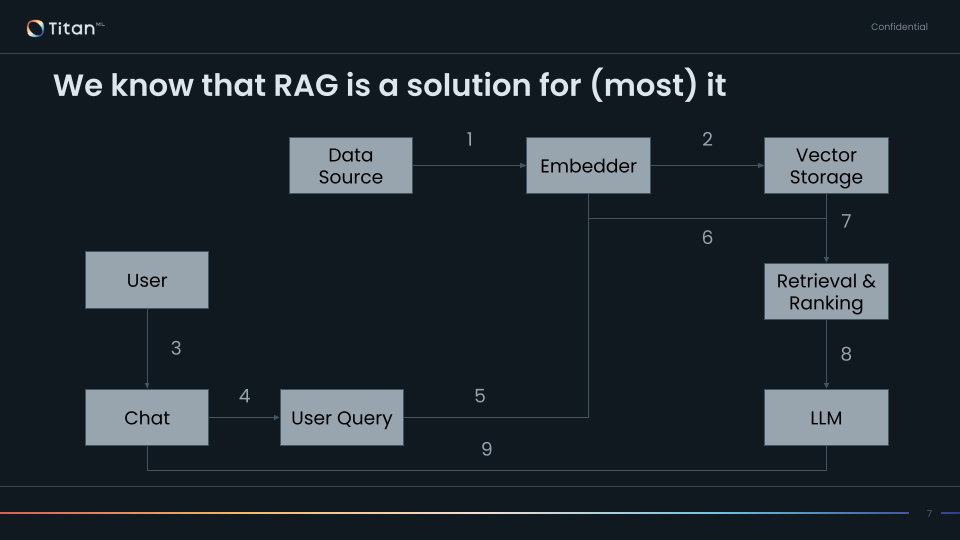

# Richer and longer representations
## with the power of embeddings!

Our next step must be now to introduce vector embeddings and storage into our architecture

# Embedding and Storage

In [ ]:
!pip install pinecone-client

In [ ]:
!pip install sentence_transformers

## Embedder
- The `setup_model` function initializes the sentence-transformers model, which will be used as our Embedder.
- We update the `Embedding` class to use the sentence-transformers model:

In [ ]:
from sentence_transformers import SentenceTransformer

class Embedding:
    def __init__(self, model_name: str, device: str = 'cpu', use_local: bool = False):
        self.model_name = model_name
        self.device = device
        self.use_local = use_local
        # Mapping of model names to their expected dimensions
        self.model_dimensions = {
            'all-MiniLM-L6-v2': 384,  # Example dimension for a SentenceTransformer model
            'TitanML/jina-v2-base-en-embed': 768,  # Specified dimension for your local model
            # Add other models and their dimensions here
        }
        self.current_model_dimension = self.model_dimensions.get(model_name, None)

        if use_local:
            self.takeoff_client = TakeoffClient(
                base_url=os.environ.get("TITAN_TAKEOFF"),
                port=os.environ.get("TITAN_TAKEOFF_PORT"),
                mgmt_port=os.environ.get("TITAN_TAKEOFF_PORT_MT")
            )
            self.switch_model(model_name, device)
        else:
            self.model = SentenceTransformer(model_name, device=device)

    def switch_model(self, model_name: str, device: str):
        # Here we assume the model switch is successful and just set the dimension
        if model_name in self.model_dimensions:
            self.current_model_dimension = self.model_dimensions[model_name]
            print(f"Switched to model '{model_name}' with dimension {self.current_model_dimension}")
        else:
            print(f"Model '{model_name}' not recognized. Unable to switch models.")

    def embed(self, text: str) -> List[float]:
        if self.use_local:
            response = self.takeoff_client.embed(text, consumer_group="embed")
            if 'result' in response:
                result = response['result'][0]
                if len(result) != self.current_model_dimension:
                    print(f"Dimension mismatch detected: Expected {self.current_model_dimension}, got {len(result)}")
                return result
            else:
                print(f"Error generating embedding: {response}")
                return []
        else:
            result = self.model.encode(text).tolist()
            if len(result) != self.current_model_dimension:
                print(f"Dimension mismatch detected: Expected {self.current_model_dimension}, got {len(result)}")
            return result

## Vector Storage
- The `setup_pinecone` function sets up the Pinecone index, which will be used as our Vector Storage.
- We create a new `PineconeVectorStorage` class that inherits from `VectorStorage` and uses Pinecone for storing and searching vectors
- We create an instance of the `Pinecone` class using the API key.
- We check if the index already exists using `self.pinecone.list_indexes().names()` and create it if it doesn't exist.
- We retrieve the index using `self.pinecone.Index(index_name)`

In [ ]:
import pinecone
from pinecone import Pinecone, ServerlessSpec

class PineconeVectorStorage(VectorStorage):
    def __init__(self, index_name: str, embedding: Embedding):
        super().__init__()
        PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY")
        self.pinecone = Pinecone(api_key=PINECONE_API_KEY)
        self.index_name = index_name

        # Get the embedding dimension
        sample_text = "This is a sample text."
        sample_embedding = embedding.embed(sample_text)
        dimension = len(sample_embedding)

        if self.index_name in self.pinecone.list_indexes().names():
            # Check if the dimension of the existing index matches the embedding dimension
            index_info = self.pinecone.describe_index(self.index_name)
            if index_info.dimension != dimension:
                # Delete the existing index
                self.pinecone.delete_index(self.index_name)
                print(f"Deleted existing index '{self.index_name}' with mismatched dimension")
            else:
                print(f"Using existing index '{self.index_name}' with matching dimension")

        if self.index_name not in self.pinecone.list_indexes().names():
            # Create a new index with the correct dimension
            self.pinecone.create_index(
                name=self.index_name,
                dimension=dimension,
                metric='cosine',
                spec=ServerlessSpec(cloud='aws', region='us-west-2')
            )
            print(f"Created new index '{self.index_name}' with dimension {dimension}")

        self.index = self.pinecone.Index(self.index_name)

    def store_vectors(self, vectors: List[List[float]], metadatas: List[dict]):
        ids = [str(i) for i in range(len(vectors))]
        records = zip(ids, vectors, metadatas)
        self.index.upsert(vectors=records)

    def search_vectors(self, query_vector: List[float], top_n: int) -> List[dict]:
        results = self.index.query(top_k=top_n, vector=query_vector, include_metadata=True, include_values=False)
        return results['matches']

##Data Source
- We update the `process_data` method in the `DataSource` class to return the processed data:

In [ ]:
class DataSource:
    def __init__(self, data: List[str]):
        self.data = data

    def preprocess_text(self, text: str) -> str:
      """
      Preprocesses the text by lowercasing, removing punctuation, and removing extra whitespace.

      Args:
          text (str): The input text to be preprocessed.

      Returns:
          str: The preprocessed text.
      """
      text = text.lower()
      text = text.translate(str.maketrans("", "", string.punctuation))
      text = re.sub(r"\s+", " ", text).strip()
      return text

    def preprocess_text_advanced(self, text: str) -> str:
        # Convert the text to lowercase
        text = text.lower()

        # Remove punctuation and numeric characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize the text
        tokens = nltk.word_tokenize(text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatize the words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join the tokens back into a string
        text = ' '.join(tokens)

        return text

    def tokenize(self, text: str) -> str:
      """
      Tokenizes the preprocessed text into a list of words.

      Args:
          text (str): The preprocessed text to be tokenized.

      Returns:
          List[str]: A list of tokens (words) from the text.
      """
      return self.preprocess_text_advanced(text).split()

    def process_data(self) -> List[str]:
      self.processed_data = [self.preprocess_text_advanced(sentence) for sentence in self.data]
      return self.processed_data

## Retrieval and Ranking
- We update the `retrieve_relevant_chunks_euclidean` method in the `RetrievalAndRanking` class to use the Pinecone vector storage for retrieval

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Create a TF-IDF vectorizer
      vectorizer = TfidfVectorizer()

      # Tokenize each string in the data source and join the tokens back into strings
      tokenized_data_source = [' '.join(self.data_source.tokenize(text)) for text in self.data_source.processed_data]

      # Fit and transform the tokenized data source
      tfidf_matrix = vectorizer.fit_transform(tokenized_data_source)

      # Tokenize the query and join the tokens back into a string
      tokenized_query = ' '.join(self.data_source.tokenize(query))

      # Transform the tokenized query
      query_vector = vectorizer.transform([tokenized_query])

      # Calculate the euclidean distance between the query and each chunk
      similarities = euclidean_distances(query_vector, tfidf_matrix).flatten()

      # Get the indices of the top-n closest chunks
      top_indices = similarities.argsort()[:top_n]

      # Return the top-n closest chunks
      return [self.data_source.processed_data[i] for i in top_indices]

    def retrieve_relevant_chunks_pinecone(self, query: str, top_n: int = 2) -> List[str]:
      query_vector = self.embedding.embed(query)
      results = self.vector_storage.search_vectors(query_vector, top_n)
      return [result['metadata']['text'] for result in results]

## process_query function
We update `process_query` as follows:
- We introduced a new `elif` condition in the `if-elif `block to check if the retrieval_method is set to "pinecone".
- If the `retrieval_method` is `"pinecone"`, we call the `retrieve_relevant_chunks_pinecone` method of the retrieval_and_ranking object.
- When `retrieval_method` is set to `"default"` or `"euclidean"`, the function continues to retrieve the relevant chunks, join them into a context string, and pass the query and context to the LLM for generating the answer, as before.
- However, when `retrieval_method` is set to `"pinecone"`, the function retrieves the relevant chunks using the `retrieve_relevant_chunks_pinecone` method, but instead of passing them to the LLM, it directly joins the relevant chunks into a single string using `"\n".join(relevant_chunks)` and assigns it to the `answer` variable.

In [ ]:
def process_query(query: str, data_source: DataSource, retrieval_and_ranking: RetrievalAndRanking, llm: LLM, retrieval_method: str = "default") -> str:
    user_query = UserQuery(query)

    if retrieval_method == "default":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks(user_query.query)
        context = "\n".join(relevant_chunks)
        answer = llm.answer_query(user_query.query, context)
    elif retrieval_method == "euclidean":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_euclidean(user_query.query)
        context = "\n".join(relevant_chunks)
        answer = llm.answer_query(user_query.query, context)
    elif retrieval_method == "pinecone":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_pinecone(user_query.query)
        answer = "\n".join(relevant_chunks)
    else:
        raise ValueError(f"Unknown retrieval method: {retrieval_method}")

    return answer

## main function
We update the `main` function:


1.   We initialize the `Embedding` and `PineconeVectorStorage` objects as before.
2.   We process the data, create metadata, and generate vectors using the `Embedding` object.
3.   We store the vectors and metadata in the `PineconeVectorStorage` object.
4.   We create the `RetrievalAndRanking` and `LLM` objects as before.
5.   Inside the query loop, we add a conditional block to determine the retrieval method based on the `retrieval_method` parameter:
- If `retrieval_method` is `"default"`, we call `process_query` with the default retrieval method.
- If `retrieval_method` is `"euclidean"`, we call `process_query` with the Euclidean distance retrieval method.
- If `retrieval_method` is `"pinecone"`, we call `process_query` with the Pinecone retrieval method.
- If `retrieval_method` is any other value, we raise a `ValueError` with an appropriate error message.
6. The rest of the loop remains the same, printing the user query and the generated answer.

In [ ]:
def main(data_source:DataSource,
         retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None,
         device: str = "cpu",
         embedding_model_name = 'all-MiniLM-L6-v2',
         use_local=False,
         index_name="my-index"
         ):
    embedding = Embedding(model_name=embedding_model_name,
                          device=device,
                          use_local=use_local)
    vector_storage = PineconeVectorStorage(index_name, embedding)
    processed_data = data_source.process_data()
    metadatas = [{'text': text} for text in processed_data]
    vectors = [embedding.embed(text) for text in processed_data]
    vector_storage.store_vectors(vectors, metadatas)
    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)

    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        llm = LLM(model_name=model_name, device=device)

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "euclidean":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "pinecone":
            answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

### Let's update

Possible queries:
- "What is the purpose of carbon trading?"
- "How do ESG criteria evaluate a company's environmental impact?"
- "What is the recipe for making a perfect pizza?"

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index4", embedding_model_name="all-MiniLM-L6-v2")

Using existing index 'my-index4' with matching dimension
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit
carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint

Enter your query (or type 'exit' to quit): exit


# Let's go local!
We can also go local and use the same models under a single API and infrastructure!

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index7", device='cuda', use_local=True, embedding_model_name="TitanML/jina-v2-base-en-embed")

Switched to model 'TitanML/jina-v2-base-en-embed' with dimension 768
Using existing index 'my-index7' with matching dimension
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit
carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint

Enter your query (or type 'exit' to quit): exit


## Exercise 3: Filtering by Metadata

- Extend the `retrieve_relevant_chunks_pinecone` method in the `RetrievalAndRanking` class to allow filtering the results based on metadata.
- Add a new parameter `filter_metadata` to the method, which should be a dictionary representing the metadata filters.
- Modify the `search_vectors` method call in the `PineconeVectorStorage` class to include the `filter_metadata` parameter.
- Test the functionality by adding metadata to the chunks and using the `filter_metadata` parameter in the `retrieve_relevant_chunks_pinecone` method.
- Don't forget to update the `process_query` and `main` functions

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Create a TF-IDF vectorizer
      vectorizer = TfidfVectorizer()

      # Tokenize each string in the data source and join the tokens back into strings
      tokenized_data_source = [' '.join(self.data_source.tokenize(text)) for text in self.data_source.processed_data]

      # Fit and transform the tokenized data source
      tfidf_matrix = vectorizer.fit_transform(tokenized_data_source)

      # Tokenize the query and join the tokens back into a string
      tokenized_query = ' '.join(self.data_source.tokenize(query))

      # Transform the tokenized query
      query_vector = vectorizer.transform([tokenized_query])

      # Calculate the euclidean distance between the query and each chunk
      similarities = euclidean_distances(query_vector, tfidf_matrix).flatten()

      # Get the indices of the top-n closest chunks
      top_indices = similarities.argsort()[:top_n]

      # Return the top-n closest chunks
      return [self.data_source.processed_data[i] for i in top_indices]

    def retrieve_relevant_chunks_pinecone(self, query: str, top_n: int = 2) -> List[str]:
      # UPDATE HERE
      query_vector = self.embedding.embed(query)
      results = self.vector_storage.search_vectors(query_vector, top_n)
      return [result['metadata']['text'] for result in results]

In [ ]:
class PineconeVectorStorage(VectorStorage):
    def __init__(self, index_name: str, embedding: Embedding):
        super().__init__()
        PINECONE_API_KEY = os.environ.get("PINECONE_API_KEY")
        self.pinecone = Pinecone(api_key=PINECONE_API_KEY)
        if index_name not in self.pinecone.list_indexes().names():
            self.pinecone.create_index(
                name=index_name,
                dimension=embedding.model.get_sentence_embedding_dimension(),
                metric='cosine',
                spec=ServerlessSpec(cloud='aws', region='us-west-2')
            )
        self.index = self.pinecone.Index(index_name)

    def store_vectors(self, vectors: List[List[float]], metadatas: List[dict]):
        ids = [str(i) for i in range(len(vectors))]
        records = zip(ids, vectors, metadatas)
        self.index.upsert(vectors=records)

    def search_vectors(self, query_vector: List[float], top_n: int) -> List[dict]:
        # Update here
        results = self.index.query(top_k=top_n, vector=query_vector, include_metadata=True, include_values=False)
        return results['matches']

In [ ]:
def main(data_source:DataSource,
         retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None,
         device: str = "cpu",
         embedding_model_name = 'all-MiniLM-L6-v2',
         use_local=False,
         index_name="my-index"
         ):
    embedding = Embedding(model_name=embedding_model_name,
                          device=device,
                          use_local=use_local)
    vector_storage = PineconeVectorStorage(index_name, embedding)
    processed_data = data_source.process_data()
    # Update here for metadata
    metadatas = [{'text': text} for text in processed_data]
    vectors = [embedding.embed(text) for text in processed_data]
    vector_storage.store_vectors(vectors, metadatas)
    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)

    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        llm = LLM(model_name=model_name, device=device)

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "euclidean":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "pinecone":
            answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

### Answer

### Let's update!


Possible queries:
- "What is the purpose of carbon trading?"
- "How do ESG criteria evaluate a company's environmental impact?"
- "What is the recipe for making a perfect pizza?"

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index4", embedding_model_name="all-MiniLM-L6-v2")

Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit
carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint

Enter your query (or type 'exit' to quit): exit


# Let's go local!
We can also go local and use the same models under a single API and infrastructure!

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index7", device='cuda', use_local=True, embedding_model_name="TitanML/jina-v2-base-en-embed")

Switched to model 'TitanML/jina-v2-base-en-embed' with dimension 768
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Query: What is the purpose of carbon trading?
Answer: goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit
carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint

Enter your query (or type 'exit' to quit): exit


## Exercise 4: Semantic Search with Multiple Queries

- Modify the `retrieve_relevant_chunks_pinecone` method in the `RetrievalAndRanking` class to accept a list of queries instead of a single query.
- Embed each query using the Sentence Transformers model and calculate the average embedding (hint use `numpy mean`).
- Use the average embedding to search for relevant chunks in Pinecone.
- Update the `process_query` and `main` function to handle multiple queries.

In [ ]:
import numpy as np

In [ ]:
class RetrievalAndRanking:
    def __init__(self, data_source: DataSource, embedding: Embedding, vector_storage: VectorStorage):
        self.data_source = data_source
        self.embedding = embedding
        self.vector_storage = vector_storage

    def retrieve_relevant_chunks(self, query: str, top_n: int = 2) -> List[str]:
      """
      Retrieves the most relevant chunks from the data source based on the query.

      Args:
          query (str): The user's query.
          top_n (int): The number of top relevant chunks to retrieve (default is 2).

      Returns:
          List[str]: The list of top relevant chunks from the data source.
      """

      query_tokens = set(self.data_source.tokenize(query))
      similarities: List[Tuple[str, float]] = []

      for chunk in self.data_source.processed_data:
          chunk_tokens = set(self.data_source.tokenize(chunk))
          similarity = len(query_tokens.intersection(chunk_tokens)) / len(
              query_tokens.union(chunk_tokens)
          )
          similarities.append((chunk, similarity))

      similarities.sort(key=lambda x: x[1], reverse=True)
      return [chunk for chunk, _ in similarities[:top_n]]

    def retrieve_relevant_chunks_euclidean(self, query: str, top_n: int = 2) -> List[str]:
      # Create a TF-IDF vectorizer
      vectorizer = TfidfVectorizer()

      # Tokenize each string in the data source and join the tokens back into strings
      tokenized_data_source = [' '.join(self.data_source.tokenize(text)) for text in self.data_source.processed_data]

      # Fit and transform the tokenized data source
      tfidf_matrix = vectorizer.fit_transform(tokenized_data_source)

      # Tokenize the query and join the tokens back into a string
      tokenized_query = ' '.join(self.data_source.tokenize(query))

      # Transform the tokenized query
      query_vector = vectorizer.transform([tokenized_query])

      # Calculate the euclidean distance between the query and each chunk
      similarities = euclidean_distances(query_vector, tfidf_matrix).flatten()

      # Get the indices of the top-n closest chunks
      top_indices = similarities.argsort()[:top_n]

      # Return the top-n closest chunks
      return [self.data_source.processed_data[i] for i in top_indices]

    def retrieve_relevant_chunks_pinecone(self, query: str, top_n: int = 2, filter_metadata: dict = None) -> List[str]:
      # MODIFY HERE
      query_vector = self.embedding.embed(query)
      results = self.vector_storage.search_vectors(query_vector, top_n, filter_metadata)
      return [result['metadata']['text'] for result in results]

In [ ]:
def process_query(query: str, data_source: DataSource, retrieval_and_ranking: RetrievalAndRanking, llm: LLM, retrieval_method: str = "default") -> str:
    # MODIFY HERE
    user_query = UserQuery(query)

    if retrieval_method == "default":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks(user_query.query)
        context = "\n".join(relevant_chunks)
        # MODIFY HERE
        answer = llm.answer_query(user_query.query, context)
    elif retrieval_method == "euclidean":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_euclidean(user_query.query)
        context = "\n".join(relevant_chunks)
        # MODIFY HERE
        answer = llm.answer_query(user_query.query, context)
    elif retrieval_method == "pinecone":
        relevant_chunks = retrieval_and_ranking.retrieve_relevant_chunks_pinecone(user_query.query, filter_metadata={'category': 'finance'})
        answer = "\n".join(relevant_chunks)
    else:
        raise ValueError(f"Unknown retrieval method: {retrieval_method}")

    return answer

In [ ]:
def main(data_source:DataSource,
         retrieval_method: str = "default",
         model_choice: str = "openai",
         model_name: str = None,
         device: str = "cpu",
         embedding_model_name = 'all-MiniLM-L6-v2',
         use_local=False,
         index_name="my-index"
         ):
    embedding = Embedding(model_name=embedding_model_name,
                          device=device,
                          use_local=use_local)
    vector_storage = PineconeVectorStorage(index_name, embedding)
    processed_data = data_source.process_data()
    # Updated here for metadata
    metadatas = [{'text': text, 'category': 'finance'} for text in processed_data]
    vectors = [embedding.embed(text) for text in processed_data]
    vector_storage.store_vectors(vectors, metadatas)


    retrieval_and_ranking = RetrievalAndRanking(data_source, embedding, vector_storage)

    if model_choice == "openai":
        llm = LLM(api_key=os.environ.get("OPENAI_API_KEY"))
    else:
        llm = LLM(model_name=model_name, device=device)

    while True:
        user_input = input("Enter your query (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        # Update here
        if retrieval_method == "default":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "euclidean":
          answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        elif retrieval_method == "pinecone":
            answer = process_query(user_input, data_source, retrieval_and_ranking, llm, retrieval_method)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

        print(f"User Query: {user_input}")
        print(f"Answer: {answer}\n")

### Answer

In the updated `retrieve_relevant_chunks_pinecone` method, we embed each query using the Sentence Transformers model, calculate the average embedding, and use it to search for relevant chunks in Pinecone.

The `process_query` function is modified to accept a list of queries instead of a single query. It creates `UserQuery` objects for each query and passes them to the appropriate retrieval method based on the `retrieval_method` parameter.

To test the functionality, we update our `main` function to handle multiple queries

### Let's update


In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index4", embedding_model_name="all-MiniLM-L6-v2")

Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Queries:
1. What is the purpose of carbon trading?

Answers:
1. goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit
carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint

Enter your query (or type 'exit' to quit): exit


# Let's go local!
We can also go local and use the same models under a single API and infrastructure!

In [ ]:
data_source = DataSource(data)
data_source.process_data()
main(data_source, retrieval_method='pinecone', index_name="my-index7", device='cuda', use_local=True, embedding_model_name="TitanML/jina-v2-base-en-embed")

Switched to model 'TitanML/jina-v2-base-en-embed' with dimension 768
Enter your query (or type 'exit' to quit): What is the purpose of carbon trading?
User Queries:
1. What is the purpose of carbon trading?

Answers:
1. goal carbon trading encourage company invest cleaner technology adopt sustainable practice reduce emission avoid cost purchasing additional carbon credit
carbon trading marketbased approach reducing greenhouse gas emission providing economic incentive company limit carbon footprint

Enter your query (or type 'exit' to quit): exit


# And we are just scratching the surface

## What about
- Multi-modal models? Ask questions about images? Ask questions about tables
- What about improving the reranking with a dedicated model?
- What about routing some queries to OpenAI and others to a local model?

All this is very difficult! But it does not need to be! More so, when there is TitanML!



# Building SOTA RAG

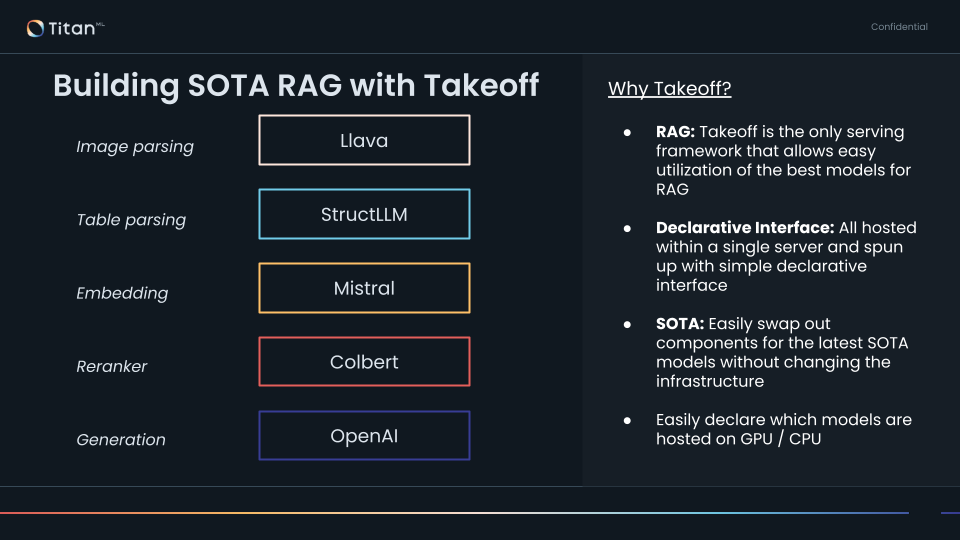

And don't forget to contact us at hello@titanml.co !